In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import colorcet as cc
import seaborn as sns
from copy import deepcopy
from toolz import partial, concat, keyfilter
from tqdm.auto import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit, GridSearchCV, cross_val_score
from aging.behavior.jax_regressor import JaxRegressor, multi_model_function, model_loss_l1
from aging.plotting import legend, format_plots, save_factory, figure, PlotConfig

In [2]:
format_plots()
c = PlotConfig()
saver = save_factory(c.save_path / "beh-stabilization", tight_layout=False)

## Longtogeny

In [3]:
version = 7  # arhmm version
df = pd.read_parquet(
    f"/n/groups/datta/win/longtogeny/data/ontogeny/version_{version:02d}/longtogeny_males_clean_v2.parquet"
)
# df.set_index(['pseudo_age', 'pseudo_age_smooth'], inplace=True, append=True)
df = df[df.index.get_level_values('age') < 600]

In [4]:
coef_shapes = {
    "exponential_params": dict(a=(1, 1), b=(1, 1), c=(1, 1), offset=(1, 1)),
    "linear_params": dict(m=(1, 1), b=(1, 1)),
    "logistic_params": dict(m=(1, 1), b=(1, 1), offset=(1, 1), scale=(1, 1)),
    "quadratic_params": dict(a=(1, 1), b=(1, 1), c=(1, 1)),
    "submodel_weights": (4, 1),
}

In [5]:
mdl = JaxRegressor(
    jit=True,
    model=multi_model_function,
    loss_fun=model_loss_l1,
    n_iter=75,
    coef_shapes=coef_shapes,
    l1=1e-1,
    lr=9e-3,
)

In [6]:
params = dict(l1=np.logspace(-5, 0, 6))

In [7]:
age_scaler = StandardScaler()
x = age_scaler.fit_transform(df.index.get_level_values('age').to_numpy()[:, None] / 7)
# y = StandardScaler().fit_transform(df)
y = df.to_numpy()
time = np.linspace(np.min(x), np.max(x), 300)[:, None]

In [8]:
cv = GridSearchCV(mdl, params, cv=ShuffleSplit(n_splits=3, test_size=0.5, random_state=0))
best_mdls = {}
grads = {}
scores = {}
for syll in tqdm(range(50)):
    cv = cv.fit(x, y[:, syll])
    best_mdls[syll] = deepcopy(cv.best_estimator_)
    grads[syll] = cv.best_estimator_.gradient(time)
    scores[syll] = cv.best_score_
    print(syll, cv.best_params_, "r2", round(cv.best_score_, 2))

  0%|          | 0/50 [00:00<?, ?it/s]

0 {'l1': 1e-05} r2 0.31
1 {'l1': 0.0001} r2 0.22
2 {'l1': 1e-05} r2 0.48
3 {'l1': 0.0001} r2 0.31
4 {'l1': 1e-05} r2 0.38
5 {'l1': 1e-05} r2 0.21
6 {'l1': 1e-05} r2 0.28
7 {'l1': 1e-05} r2 0.05
8 {'l1': 1e-05} r2 0.25
9 {'l1': 1e-05} r2 0.12
10 {'l1': 0.001} r2 0.01
11 {'l1': 1e-05} r2 0.15
12 {'l1': 0.001} r2 0.01
13 {'l1': 1e-05} r2 0.02
14 {'l1': 0.0001} r2 0.23
15 {'l1': 0.0001} r2 0.03
16 {'l1': 1e-05} r2 0.4
17 {'l1': 1e-05} r2 0.06
18 {'l1': 1e-05} r2 0.17
19 {'l1': 1e-05} r2 0.08
20 {'l1': 1e-05} r2 -0.01
21 {'l1': 1e-05} r2 0.03
22 {'l1': 1e-05} r2 0.19
23 {'l1': 0.001} r2 -0.0
24 {'l1': 0.001} r2 -0.02
25 {'l1': 0.0001} r2 0.23
26 {'l1': 1e-05} r2 0.18
27 {'l1': 0.001} r2 0.26
28 {'l1': 1e-05} r2 0.57
29 {'l1': 1e-05} r2 0.03
30 {'l1': 0.0001} r2 -0.01
31 {'l1': 0.0001} r2 0.11
32 {'l1': 0.0001} r2 0.06
33 {'l1': 0.0001} r2 0.01
34 {'l1': 0.0001} r2 0.26
35 {'l1': 1e-05} r2 0.72
36 {'l1': 1e-05} r2 0.42
37 {'l1': 1e-05} r2 0.01
38 {'l1': 1e-05} r2 0.13
39 {'l1': 0.001} r2 0.0

In [9]:
# best_mdls = {}
# grads = {}
# scores = {}
# for syll in tqdm(range(50)):
#     scores[syll] = cross_val_score(
#         mdl, x, y[:, syll], cv=ShuffleSplit(n_splits=4, test_size=0.35, random_state=0)
#     )
#     est = deepcopy(mdl).fit(x, y[:, syll])
#     best_mdls[syll] = est
#     grads[syll] = est.gradient(time)

In [10]:
score_thresh = 0.15
keep_mdls = keyfilter(lambda k: scores[k].mean() > score_thresh, best_mdls)
keep_grads = keyfilter(lambda k: scores[k].mean() > score_thresh, grads)

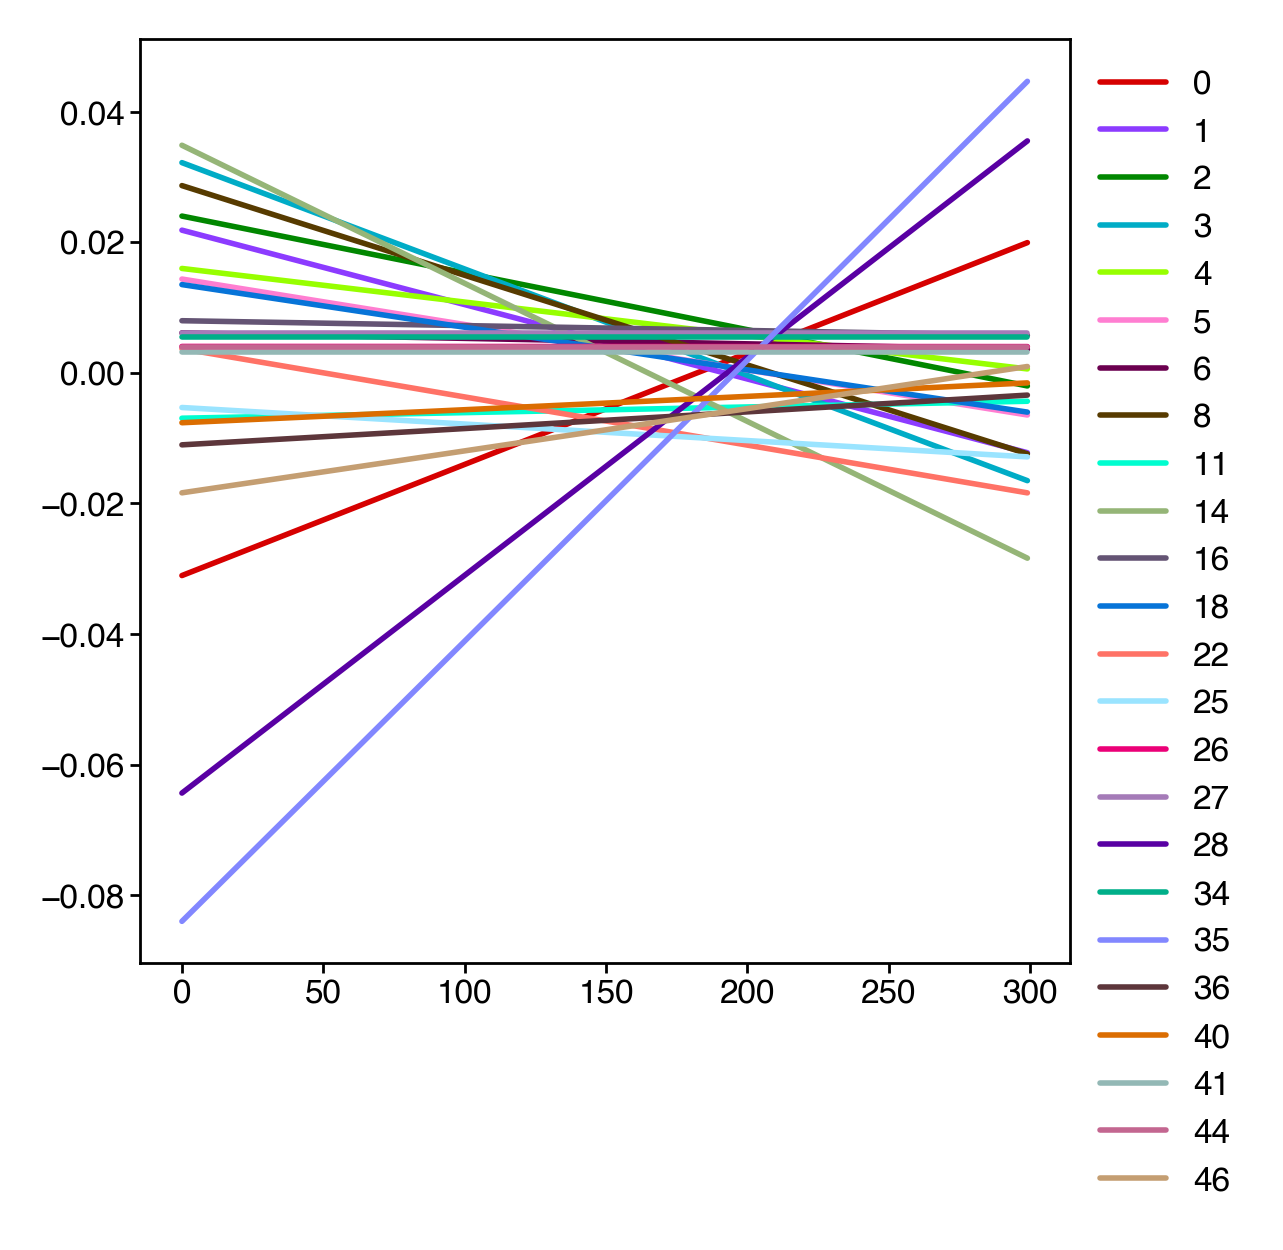

In [11]:
for k, v in keep_grads.items():
    plt.plot(v, label=k, c=cc.glasbey[k])
legend()

In [12]:
grad_array = np.array(list(keep_grads.values()))

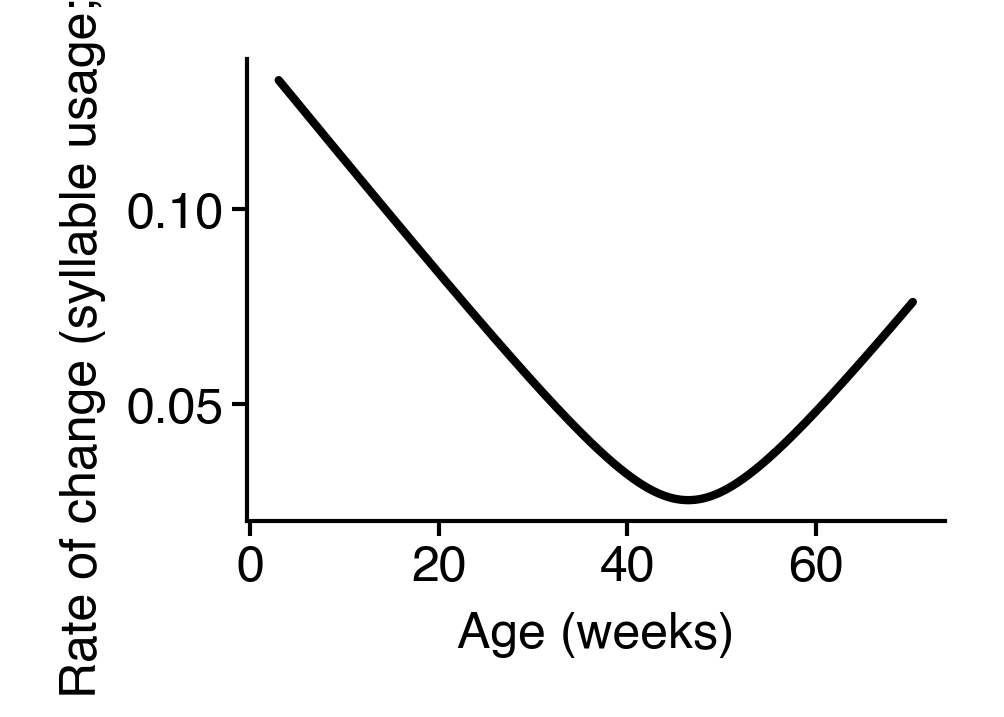

In [13]:
fig = figure(1.5, 1)
plt.plot(age_scaler.inverse_transform(time), np.linalg.norm(grad_array, axis=0), c='k')
plt.ylabel("Rate of change (syllable usage; a.u.)")
plt.xlabel('Age (weeks)')
sns.despine()
# saver(fig, "longtogeny-v1-males-rate-of-change");

In [ ]:
syll_ = 4
plt.plot(x, y[:, syll_], 'o')
plt.plot(time, keep_mdls[syll_].predict(time))

## Ontogeny

### Males

In [3]:
version = 7  # arhmm version
df = pd.read_parquet(
    f"/n/groups/datta/win/longtogeny/data/ontogeny/version_{version:02d}/ontogeny_males_clean_v2.parquet"
)

# df.set_index(['pseudotime_rank', 'pseudotime_dist'], inplace=True, append=True)
# df = df.sort_index(level='pseudotime_rank')

In [ ]:
# count_map = df.groupby('age')['0'].count()
# count_map

In [ ]:
# ages = list(concat([i] * n for i, n in count_map.items()))
# df['pseudo_age'] = ages
# df.set_index('pseudo_age', inplace=True, append=True)

In [4]:
coef_shapes = {
    "exponential_params": dict(a=(1, 1), b=(1, 1), c=(1, 1), offset=(1, 1)),
    "linear_params": dict(m=(1, 1), b=(1, 1)),
    "logistic_params": dict(m=(1, 1), b=(1, 1), offset=(1, 1), scale=(1, 1)),
    "quadratic_params": dict(a=(1, 1), b=(1, 1), c=(1, 1)),
    "submodel_weights": (4, 1),
}

In [10]:
mdl = JaxRegressor(
    jit=True,
    model=multi_model_function,
    loss_fun=model_loss_l1,
    n_iter=50,
    coef_shapes=coef_shapes,
    l1=1e-3,
    lr=1e-1,
)

In [6]:
age_scaler = StandardScaler()
x = age_scaler.fit_transform(df.index.get_level_values('age').to_numpy()[:, None])
y = StandardScaler().fit_transform(df)
time = np.linspace(np.min(x), np.max(x), 300)[:, None]

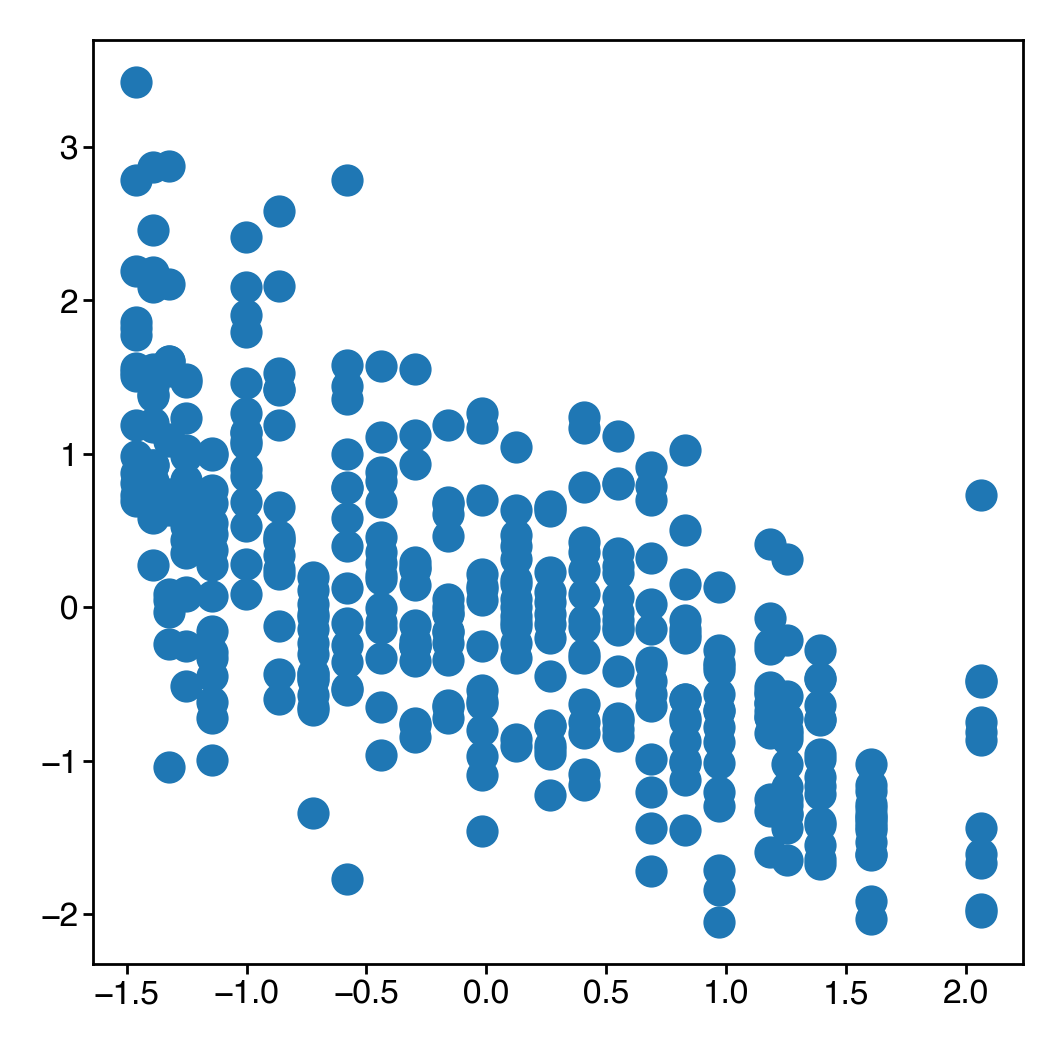

In [7]:
plt.plot(x, y[:, 0], 'o')

In [11]:
# params = dict(
#     l1=np.logspace(-5, -1, 9).tolist() + np.arange(0.2, 1.1, 0.2).tolist(),
# )

In [12]:
params = dict(l1=np.logspace(-5, 0, 6))

In [13]:
cv = GridSearchCV(mdl, params, cv=ShuffleSplit(n_splits=3, test_size=0.5, random_state=0))
best_mdls = {}
grads = {}
scores = {}
for syll in tqdm(range(50)):
    cv = cv.fit(x, y[:, syll])
    print(syll, cv.best_params_, round(cv.best_score_, 2))
    est = deepcopy(cv.best_estimator_).fit(x, y[:, syll])
    best_mdls[syll] = est
    grads[syll] = est.gradient(time)
    scores[syll] = cv.best_score_

  0%|          | 0/50 [00:00<?, ?it/s]

0 {'l1': 0.1} 0.43
1 {'l1': 0.1} 0.46
2 {'l1': 0.1} 0.53
3 {'l1': 0.0001} 0.5
4 {'l1': 0.01} 0.39
5 {'l1': 0.1} 0.32
6 {'l1': 0.0001} 0.44
7 {'l1': 0.1} -0.01
8 {'l1': 0.1} 0.39
9 {'l1': 1e-05} 0.15
10 {'l1': 0.1} 0.39
11 {'l1': 0.001} 0.35
12 {'l1': 0.1} 0.01
13 {'l1': 0.01} 0.05
14 {'l1': 0.01} 0.08
15 {'l1': 0.1} 0.5
16 {'l1': 0.001} 0.16
17 {'l1': 0.1} -0.04
18 {'l1': 0.01} 0.03
19 {'l1': 0.1} 0.34
20 {'l1': 0.1} 0.13
21 {'l1': 0.01} 0.03
22 {'l1': 1e-05} 0.06
23 {'l1': 0.01} 0.2
24 {'l1': 1e-05} 0.39
25 {'l1': 0.1} 0.22
26 {'l1': 0.01} 0.4
27 {'l1': 0.0001} 0.29
28 {'l1': 0.001} 0.32
29 {'l1': 0.1} 0.19
30 {'l1': 0.1} 0.0
31 {'l1': 1e-05} -0.01
32 {'l1': 0.01} 0.05
33 {'l1': 0.1} 0.31
34 {'l1': 0.01} 0.54
35 {'l1': 1e-05} 0.14
36 {'l1': 0.0001} -0.0
37 {'l1': 0.1} 0.6
38 {'l1': 0.001} 0.73
39 {'l1': 0.1} 0.36
40 {'l1': 0.1} -0.01
41 {'l1': 0.1} 0.27
42 {'l1': 1e-05} 0.28
43 {'l1': 0.001} 0.08
44 {'l1': 0.1} 0.31
45 {'l1': 0.01} 0.21
46 {'l1': 0.1} 0.3
47 {'l1': 0.1} 0.03
48 {'l1':

In [14]:
score_thresh = 0.15
keep_mdls = keyfilter(lambda k: scores[k] > score_thresh, best_mdls)
keep_grads = keyfilter(lambda k: scores[k] > score_thresh, grads)

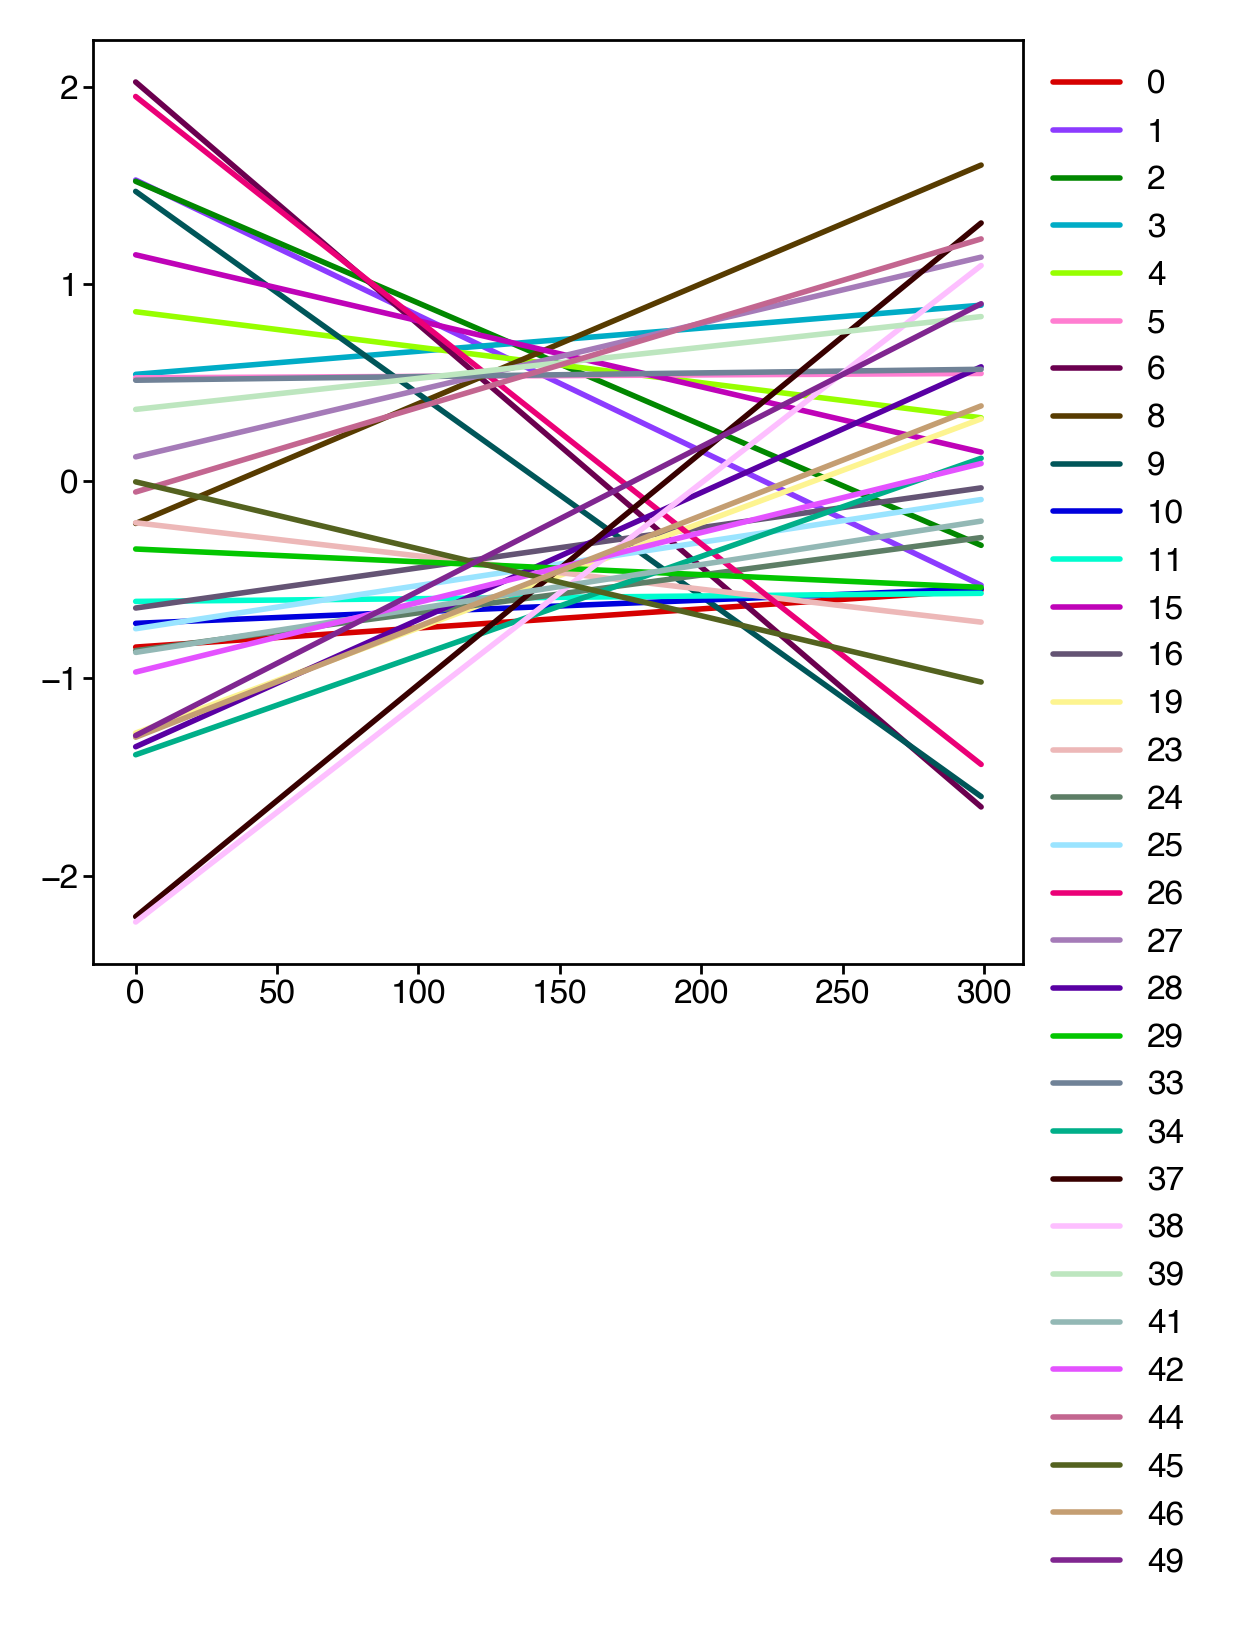

In [15]:
for k, v in keep_grads.items():
    plt.plot(v, label=k, c=cc.glasbey[k])
legend()

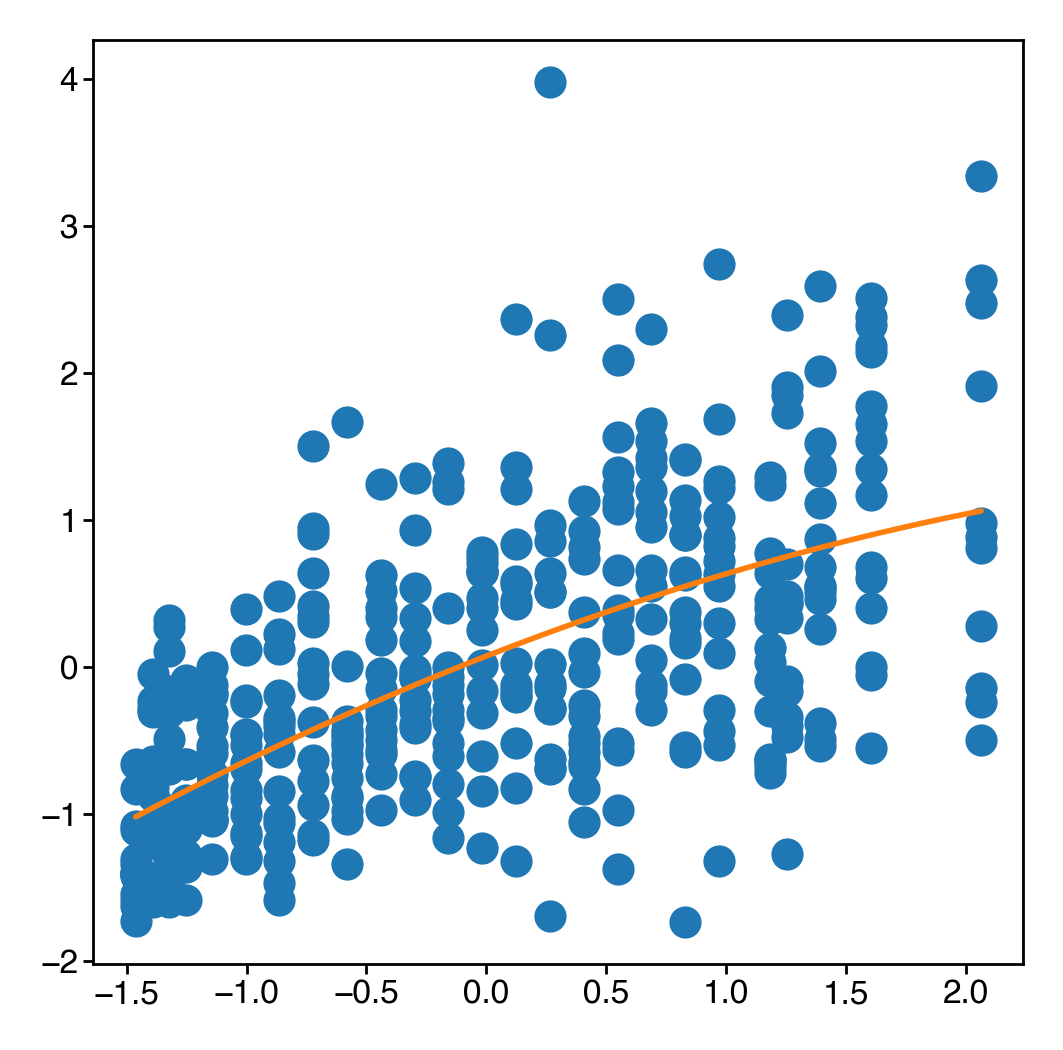

In [16]:
syll_ = 4
plt.plot(x, y[:, syll_], 'o')
plt.plot(time, keep_mdls[syll_].predict(time))

In [17]:
grad_array = np.array(list(keep_grads.values()))

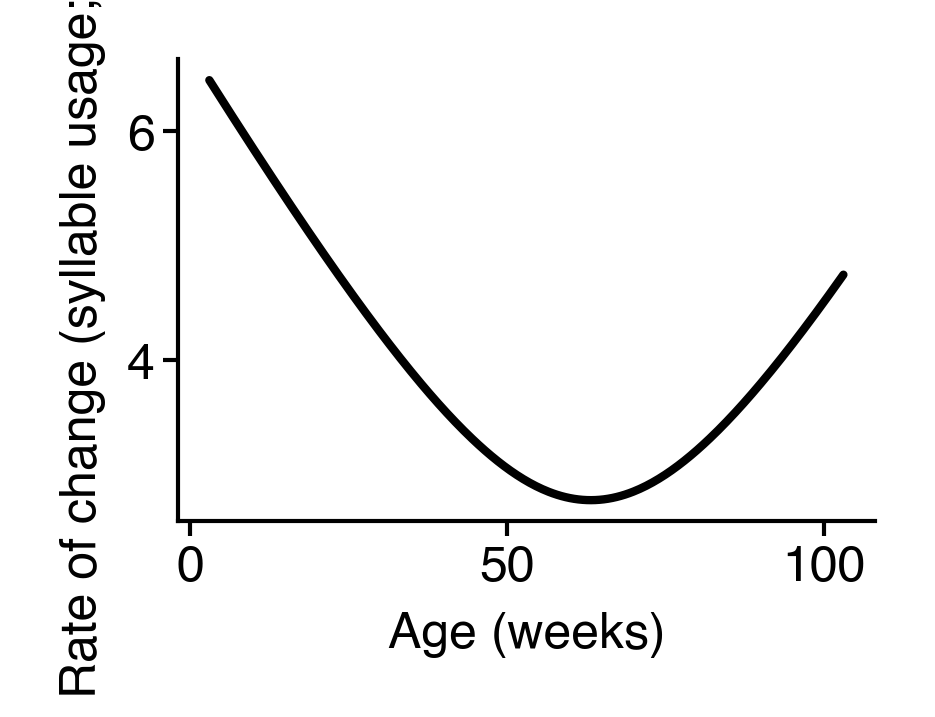

In [18]:
fig = figure(1.5, 1)
plt.plot(age_scaler.inverse_transform(time), np.linalg.norm(grad_array, axis=0), c='k')
plt.ylabel("Rate of change (syllable usage; a.u.)")
plt.xlabel('Age (weeks)')
sns.despine()
saver(fig, "ontogeny-rate-of-change");

## Females

In [21]:
version = 7  # arhmm version
df = pd.read_parquet(
    f"/n/groups/datta/win/longtogeny/data/ontogeny/version_{version:02d}/ontogeny_females_clean_v2.parquet"
)

In [22]:
coef_shapes = {
    "exponential_params": dict(a=(1, 1), b=(1, 1), c=(1, 1), offset=(1, 1)),
    "linear_params": dict(m=(1, 1), b=(1, 1)),
    "logistic_params": dict(m=(1, 1), b=(1, 1), offset=(1, 1), scale=(1, 1)),
    "quadratic_params": dict(a=(1, 1), b=(1, 1), c=(1, 1)),
    "submodel_weights": (4, 1),
}

In [23]:
mdl = JaxRegressor(
    jit=True,
    model=multi_model_function,
    loss_fun=model_loss_l1,
    n_iter=50,
    coef_shapes=coef_shapes,
    l1=1e-3,
    lr=1e-1,
)

In [24]:
age_scaler = StandardScaler()
x = age_scaler.fit_transform(df.index.get_level_values('age').to_numpy()[:, None])
y = StandardScaler().fit_transform(df)
time = np.linspace(np.min(x), np.max(x), 300)[:, None]

In [12]:
params = dict(l1=np.logspace(-5, 0, 6))

In [26]:
cv = GridSearchCV(mdl, params, cv=ShuffleSplit(n_splits=3, test_size=0.5, random_state=0))
best_mdls = {}
grads = {}
scores = {}
for syll in tqdm(range(50)):
    cv = cv.fit(x, y[:, syll])
    print(syll, cv.best_params_, round(cv.best_score_, 2))
    est = deepcopy(cv.best_estimator_).fit(x, y[:, syll])
    best_mdls[syll] = est
    grads[syll] = est.gradient(time)
    scores[syll] = cv.best_score_

  0%|          | 0/50 [00:00<?, ?it/s]

0 {'l1': 0.1} 0.52
1 {'l1': 0.1} 0.46
2 {'l1': 0.001} 0.3
3 {'l1': 0.001} 0.16
4 {'l1': 0.1} 0.3
5 {'l1': 0.01} 0.21
6 {'l1': 0.001} 0.27
7 {'l1': 1e-05} 0.12
8 {'l1': 0.0001} 0.21
9 {'l1': 0.1} 0.33
10 {'l1': 1e-05} 0.08
11 {'l1': 1e-05} 0.08
12 {'l1': 1e-05} 0.14
13 {'l1': 0.0001} 0.02
14 {'l1': 0.0001} 0.21
15 {'l1': 0.1} 0.35
16 {'l1': 0.001} 0.31
17 {'l1': 0.01} 0.03
18 {'l1': 0.1} 0.05
19 {'l1': 1e-05} 0.19
20 {'l1': 1e-05} -0.01
21 {'l1': 1e-05} 0.03
22 {'l1': 0.01} 0.14
23 {'l1': 0.01} 0.05
24 {'l1': 0.1} -0.02
25 {'l1': 0.01} 0.22
26 {'l1': 1e-05} 0.43
27 {'l1': 0.1} 0.38
28 {'l1': 1e-05} 0.5
29 {'l1': 1e-05} 0.15
30 {'l1': 0.1} 0.34
31 {'l1': 0.1} 0.38
32 {'l1': 0.01} 0.44
33 {'l1': 1e-05} 0.12
34 {'l1': 0.1} 0.37
35 {'l1': 1e-05} 0.62
36 {'l1': 1e-05} 0.29
37 {'l1': 1e-05} 0.19
38 {'l1': 1e-05} 0.3
39 {'l1': 1e-05} -0.01
40 {'l1': 0.01} 0.1
41 {'l1': 0.1} 0.16
42 {'l1': 0.01} -0.01
43 {'l1': 1e-05} 0.2
44 {'l1': 1e-05} 0.12
45 {'l1': 1e-05} 0.06
46 {'l1': 0.01} 0.36
47 {'l1'

In [27]:
score_thresh = 0.15
keep_mdls = keyfilter(lambda k: scores[k] > score_thresh, best_mdls)
keep_grads = keyfilter(lambda k: scores[k] > score_thresh, grads)

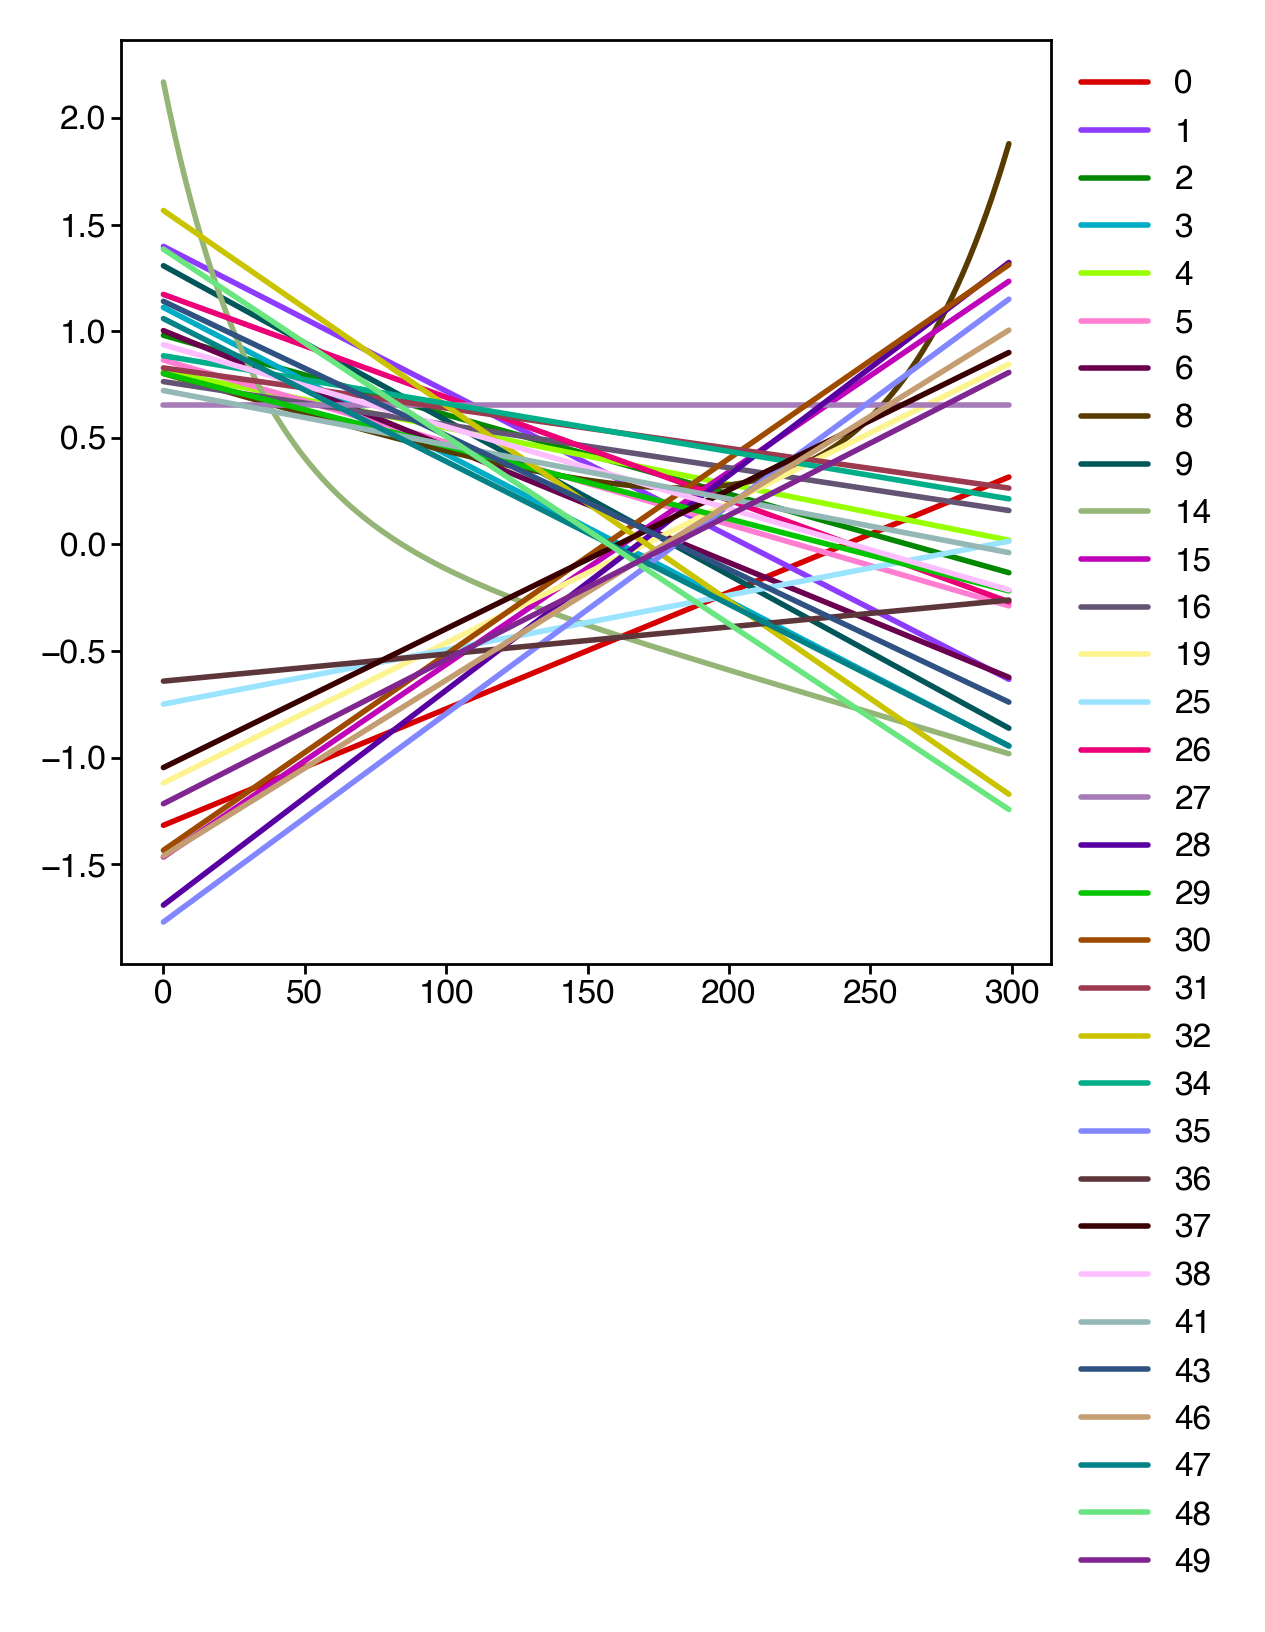

In [28]:
for k, v in keep_grads.items():
    plt.plot(v, label=k, c=cc.glasbey[k])
legend()

In [29]:
grad_array = np.array(list(keep_grads.values()))

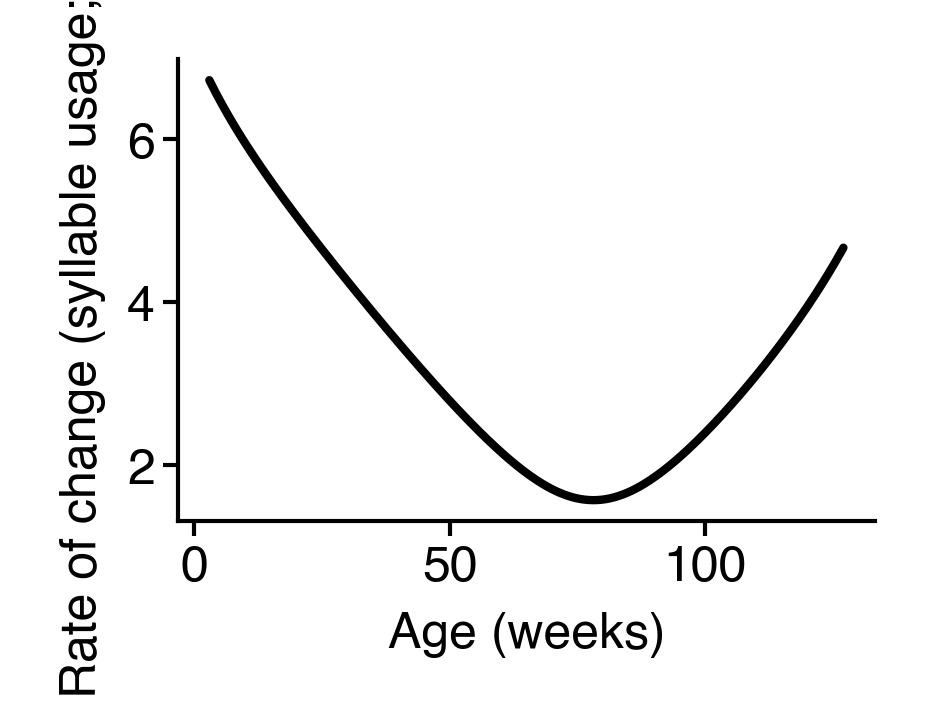

In [30]:
fig = figure(1.5, 1)
plt.plot(age_scaler.inverse_transform(time), np.linalg.norm(grad_array, axis=0), c='k')
plt.ylabel("Rate of change (syllable usage; a.u.)")
plt.xlabel('Age (weeks)')
sns.despine()
saver(fig, "female-ontogeny-rate-of-change");

## Longtogeny v2

### Males

In [95]:
version = 7  # arhmm version
df = pd.read_parquet(
    f"/n/groups/datta/win/longtogeny/data/ontogeny/version_{version:02d}/longv2_males_clean_v2.parquet"
)
# df.set_index(['pseudo_age', 'pseudo_age_smooth'], inplace=True, append=True)
# df = df[df.index.get_level_values('age') < 600]

In [97]:
coef_shapes = {
    "exponential_params": dict(a=(1, 1), b=(1, 1), c=(1, 1), offset=(1, 1)),
    "linear_params": dict(m=(1, 1), b=(1, 1)),
    "logistic_params": dict(m=(1, 1), b=(1, 1), offset=(1, 1), scale=(1, 1)),
    "quadratic_params": dict(a=(1, 1), b=(1, 1), c=(1, 1)),
    "submodel_weights": (4, 1),
}

In [98]:
mdl = JaxRegressor(
    jit=True,
    model=multi_model_function,
    loss_fun=model_loss_l1,
    n_iter=50,
    coef_shapes=coef_shapes,
    l1=1e-1,
    lr=1e-1,
)

In [101]:
age_scaler = StandardScaler()
x = age_scaler.fit_transform(df.index.get_level_values('age').to_numpy()[:, None])
y = StandardScaler().fit_transform(df)
time = np.linspace(np.min(x), np.max(x), 300)[:, None]

In [102]:
best_mdls = {}
grads = {}
scores = {}
for syll in tqdm(range(50)):
    scores[syll] = cross_val_score(
        mdl, x, y[:, syll], cv=ShuffleSplit(n_splits=4, test_size=0.35, random_state=0)
    )
    est = deepcopy(mdl).fit(x, y[:, syll])
    best_mdls[syll] = est
    grads[syll] = est.gradient(time)

  0%|          | 0/50 [00:00<?, ?it/s]

In [103]:
score_thresh = 0.15
keep_mdls = keyfilter(lambda k: scores[k].mean() > score_thresh, best_mdls)
keep_grads = keyfilter(lambda k: scores[k].mean() > score_thresh, grads)

In [104]:
grad_array = np.array(list(keep_grads.values()))

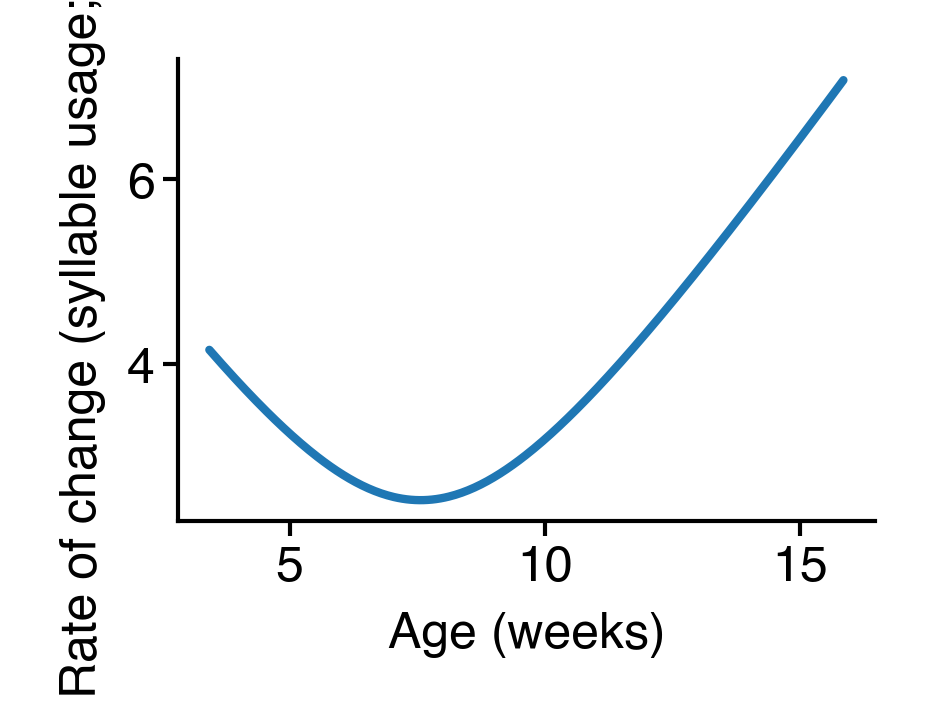

In [107]:
fig = figure(1.5, 1)
plt.plot(age_scaler.inverse_transform(time) / 7, np.linalg.norm(grad_array, axis=0))
plt.ylabel("Rate of change (syllable usage; a.u.)")
plt.xlabel('Age (weeks)')
sns.despine()
saver(fig, "longtogeny-v2-males-rate-of-change");

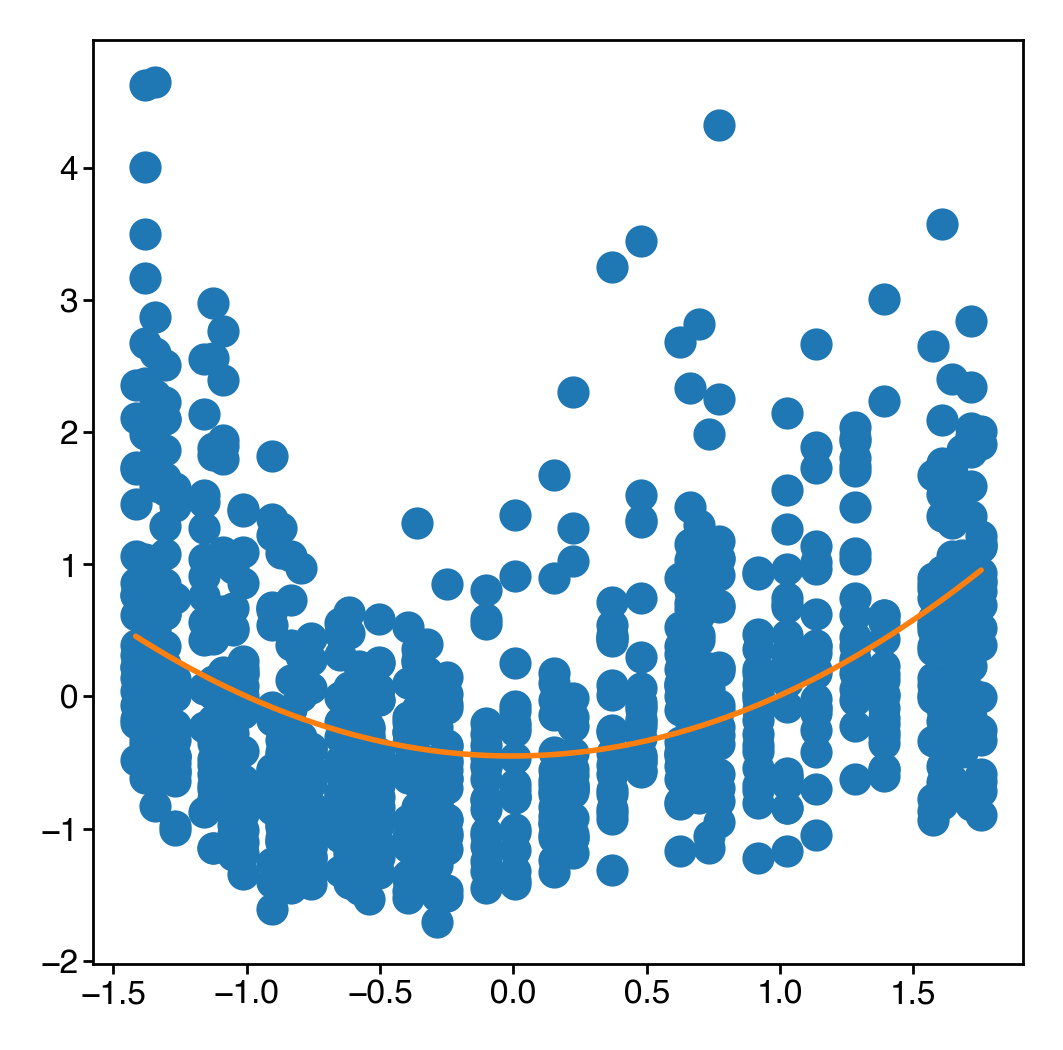

In [106]:
syll_ = 4
plt.plot(x, y[:, syll_], 'o')
plt.plot(time, keep_mdls[syll_].predict(time))

### Females

In [116]:
version = 7  # arhmm version
df = pd.read_parquet(
    f"/n/groups/datta/win/longtogeny/data/ontogeny/version_{version:02d}/longv2_females_clean_v2.parquet"
)
# df.set_index(['pseudo_age', 'pseudo_age_smooth'], inplace=True, append=True)
# df = df[df.index.get_level_values('age') < 600]

In [117]:
mdl = JaxRegressor(
    jit=True,
    model=multi_model_function,
    loss_fun=model_loss_l1,
    n_iter=50,
    coef_shapes=coef_shapes,
    l1=1e-1,
    lr=1e-1,
)

In [118]:
x = age_scaler.transform(df.index.get_level_values('age').to_numpy()[:, None])
y = StandardScaler().fit_transform(df)

In [119]:
best_mdls = {}
grads = {}
scores = {}
for syll in tqdm(range(50)):
    scores[syll] = cross_val_score(
        mdl, x, y[:, syll], cv=ShuffleSplit(n_splits=4, test_size=0.35, random_state=0)
    )
    est = deepcopy(mdl).fit(x, y[:, syll])
    best_mdls[syll] = est
    grads[syll] = est.gradient(time)

  0%|          | 0/50 [00:00<?, ?it/s]

In [120]:
score_thresh = 0.15
keep_mdls = keyfilter(lambda k: scores[k].mean() > score_thresh, best_mdls)
keep_grads = keyfilter(lambda k: scores[k].mean() > score_thresh, grads)

In [121]:
f_grad_array = np.array(list(keep_grads.values()))

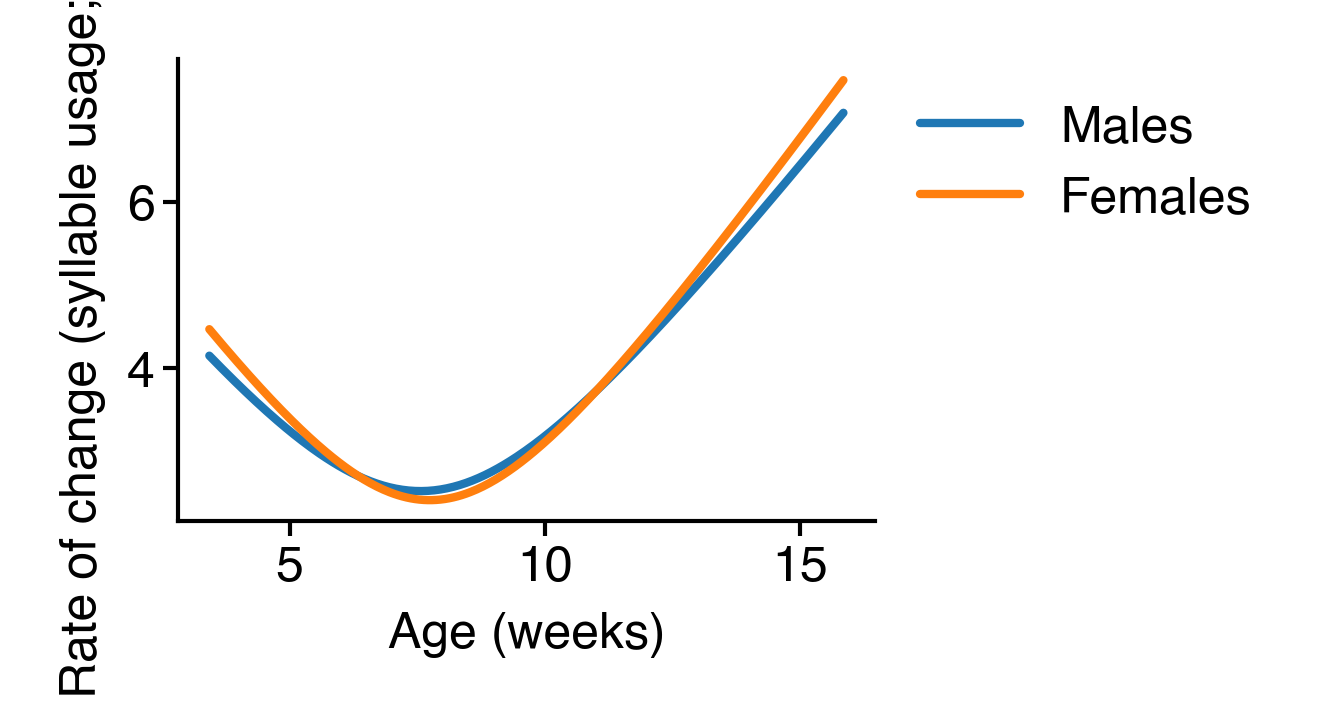

In [122]:
fig = figure(1.5, 1)
plt.plot(age_scaler.inverse_transform(time) / 7, np.linalg.norm(grad_array, axis=0), label="Males")
plt.plot(age_scaler.inverse_transform(time) / 7, np.linalg.norm(f_grad_array, axis=0), label="Females")
plt.ylabel("Rate of change (syllable usage; a.u.)")
plt.xlabel('Age (weeks)')
sns.despine()
legend()
saver(fig, "longtogeny-v2-males-females-rate-of-change");

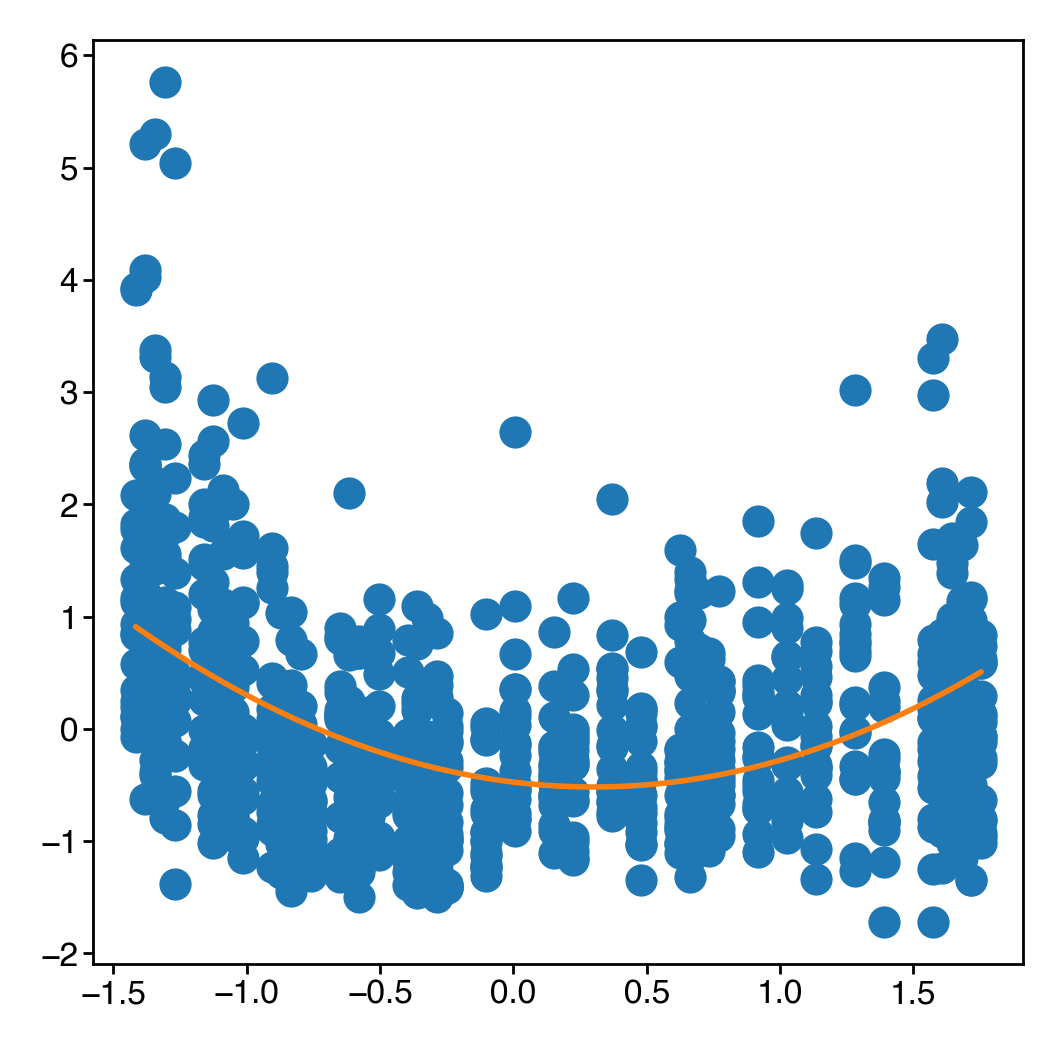

In [123]:
syll_ = 4
plt.plot(x, y[:, syll_], 'o')
plt.plot(time, keep_mdls[syll_].predict(time))